# Deskripsi Proyek
Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, kamu bisa dengan cepat mengetahui nilai pasar mobilmu. Kamu memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan. Tugasmu adalah membuat suatu model yang mampu menentukan nilai pasar mobil.
Rusty Bargain tertarik pada:

- kualitas prediksi;
- kecepatan model dalam memprediksi;
- waktu yang diperlukan untuk melatih model

## Persiapan Data

In [1]:
# Import Library untuk mengolah data
import pandas as pd, numpy as np

# Import Library untuk data viz
import matplotlib.pyplot as plt, seaborn as sns


# Import Library untuk Machine Learning
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import time

In [2]:
# Load dataset
path = 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv'
df = pd.read_csv(path)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
# Mendapatkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<div class="alert-info">
    

<b>Note</b>

<b>DateCrawled</b> — tanggal ketika profil diunduh dari database - data is OK <br>
<b>VehicleType</b> — jenis bodi kendaraan - Terdapat data yang hilang, Perlu dicek lebih lanjut <br>
<b>RegistrationYear</b> — tahun registrasi kendaraan - Data is OK! <br>
<b>Gearbox</b> — jenis transmisi - Terdapat data yang hilang, Perlu di cek lebih lanjut <br>
<b>Power</b> — daya (hp) - Data is OK<br>
<b>Model</b> — model kendaraan - Terdapat data yang hilang, perlu dicek lebih lanjut <br>
<b>Mileage</b> — jarak tempuh (diukur dalam satuan km berdasarkan dataset regional tertentu) - Data is OK! <br>
<b>RegistrationMonth</b> — bulan registrasi kendaraan - Data is OK!<br>
<b>FuelType</b> — jenis bahan bakar - Terdapat data yang hilang, Perlu di cek lebih lanjut. <br>
<b>Brand</b> — merek kendaraan - Data is OK!<br>
<b>NotRepaired</b> — apakah kendaraan pernah direparasi sebelumnya - Terdapat data yang hilang, Perlu dicek lebih lanjut <br>
<b>DateCreated</b> — tanggal pembuatan profil - Data is OK! <br>
<b>NumberOfPictures</b> — jumlah gambar kendaraan - Data is OK!<br>
<b>PostalCode</b> — kode pos pemilik profil (pengguna) - Data is OK! <br>
<b>LastSeen</b> — tanggal aktivitas terakhir pengguna - Data is OK! <br>


<b>Price</b> — harga (dalam satuan Euro) - Data is OK! <br>


### Data yang hilang

#### VehicleType

In [4]:
# Melihat data Vehicle Type.
print(df.VehicleType.value_counts())
print(f'data yang hilang pada kolom VehicleType    : {df.VehicleType.isna().sum()}')

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
data yang hilang pada kolom VehicleType    : 37490


<div class="alert-info">
    

<b>Insight</b>

- Data Tipe Kendaraan yang hilang sebanyak 37,484 data.
- 3 Tipe data terbanyak yaitu Sedan, Small dan Wagon.

In [5]:
# Mengubah data yang hilang pada kolom Vehicle Type menjadi Other
df.VehicleType = df.VehicleType.fillna('other')

In [6]:
# Melakukan pengecekan data kembali
print(df.VehicleType.value_counts())
print(f'data yang hilang pada kolom VehicleType    : {df.VehicleType.isna().sum()}')

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: VehicleType, dtype: int64
data yang hilang pada kolom VehicleType    : 0


<div class="alert-info">
    

<b>Note</b>

- Data yang hilang sudah berhasil diisi

#### Gearbox

In [7]:
# Melihat data Jenis Transmisi.
print(df.Gearbox.value_counts())
print(f'data yang hilang pada kolom Gearbox    : {df.Gearbox.isna().sum()}')

manual    268251
auto       66285
Name: Gearbox, dtype: int64
data yang hilang pada kolom Gearbox    : 19833


<div class="alert-info">
    

<b>Insight</b>

- Rata-rata jenis transmisi kendaraan yaitu Manual
- Data yang hilang sebanyak 19,830 data dari 354,369 data

In [8]:
# Mengubah data yang hilang pada kolom Gearbox menjadi nilai rata-ratanya yaitu Manual
df.Gearbox = df.Gearbox.fillna('manual')

In [9]:
# Melakukan pengecekan data kembali.
print(df.Gearbox.value_counts())
print(f'data yang hilang pada kolom Gearbox    : {df.Gearbox.isna().sum()}')

manual    288084
auto       66285
Name: Gearbox, dtype: int64
data yang hilang pada kolom Gearbox    : 0


<div class="alert-info">
    

<b>Note</b>

- Data yang hilang sudah berhasil diisi

#### Model

In [10]:
# Melihat data Model.
df.Model.value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [11]:
# Melakukan pengecekan banyaknya data yang hilang pada kolom Model
print(f'Data yang hilang pada kolom model    : {df.Model.isna().sum()}')

Data yang hilang pada kolom model    : 19705


<div class="alert-info">
    

<b>Insight</b>

- Data mencatat, kendaraan memiliki lebih dari 200 Model
- Data model kendaraan yang hilang sebanyak 19,701 Model

In [12]:
# Mengubah data yang hilang pada kolom Model menjadi other
df.Model = df.Model.fillna('other')

In [13]:
# Melakukan pengecekan kembali
print(df.Model.value_counts())
print(f'Data yang hilang pada kolom model    : {df.Model.isna().sum()}')

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64
Data yang hilang pada kolom model    : 0


<div class="alert-info">
    

<b>Note</b>

- Data yang hilang sudah berhasil diisi

#### FuelType

In [14]:
# Melihat data Jenis Bahan Bakar .
print(df.FuelType.value_counts())
print(f'Data yang hilang pada kolom Fueltype    : {df.FuelType.isna().sum()}')

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
Data yang hilang pada kolom Fueltype    : 32895


<div class="alert-info">
    

<b>Insight</b>

- Rata-rata jenis bahan bakar kendaraan, yaitu Petrol
- data yang hilang sebanyak 32,889 data

In [15]:
# Mengubah data yang hilang pada kolom FuelType menjadi other
df.FuelType = df.FuelType.fillna('other')

In [16]:
# Melakukan pengecekan kembali.
print(df.FuelType.value_counts())
print(f'Data yang hilang pada kolom Fueltype    : {df.FuelType.isna().sum()}')

petrol      216352
gasoline     98720
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: FuelType, dtype: int64
Data yang hilang pada kolom Fueltype    : 0


<div class="alert-info">
    

<b>Note</b>

- Data yang hilang sudah berhasil diisi

#### NotRepaired

In [17]:
# Melihat data reparasi .
print(df.NotRepaired.value_counts())
print(f'Data yang hilang pada kolom Fueltype    : {df.NotRepaired.isna().sum()}')

no     247161
yes     36054
Name: NotRepaired, dtype: int64
Data yang hilang pada kolom Fueltype    : 71154


<div class="alert-info">
    

<b>Insight</b>

- Rata-rata kendaraan belum pernah direparasi
- data yang hilang sebanyak 71,145 data

In [18]:
# Mengubah data yang hilang pada kolom NotRepaired menjadi nilai rata-ratanya yaitu : no
df.NotRepaired = df.NotRepaired.fillna('no')

In [19]:
# Melakukan pengecekan data kembali
print(df.NotRepaired.value_counts())
print(f'Data yang hilang pada kolom Fueltype    : {df.NotRepaired.isna().sum()}')

no     318315
yes     36054
Name: NotRepaired, dtype: int64
Data yang hilang pada kolom Fueltype    : 0


<div class="alert-info">
    

<b>Note</b>

- Data yang hilang sudah berhasil diisi

In [20]:
df.tail(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,21/03/2016 09:50,0,other,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,other,2005,manual,0,other,20000,1,other,sonstige_autos,no,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15
354368,20/03/2016 19:41,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,no,20/03/2016 00:00,0,40764,24/03/2016 12:45


### Data Duplikat

In [21]:
# Melakukan pengecekan data duplikat
df.duplicated().sum()

294

In [22]:
# Menghapus data duplikat agar tidak terjadi informasi redundant
df = df.drop_duplicates()

In [23]:
# Melakukan pengecekan kembali
df.duplicated().sum()

0

### Data Preprocessing


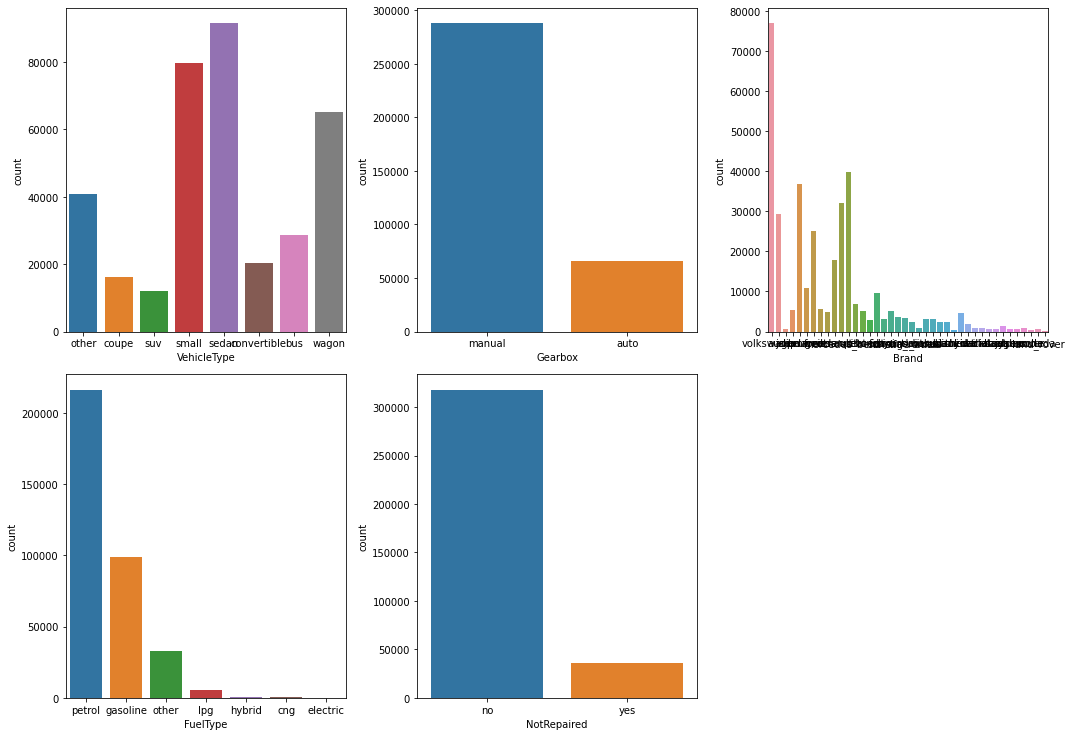

In [24]:
# Melihat persebaran data kategorikal
plt.subplots(figsize=(15, 15))
 
# melihat persebaran data categorikal
categorical = ['VehicleType', 'Gearbox', 'Brand', 'FuelType', 'NotRepaired']
 
for i, col in enumerate(categorical):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=df, x=col)
     
plt.tight_layout()
plt.show()

<div class="alert-info">
    

<b>Note</b>

- Varian produk Brand terlalu banyak, sehingga nantinya tidak digunakan sebagai fitur dalam model.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

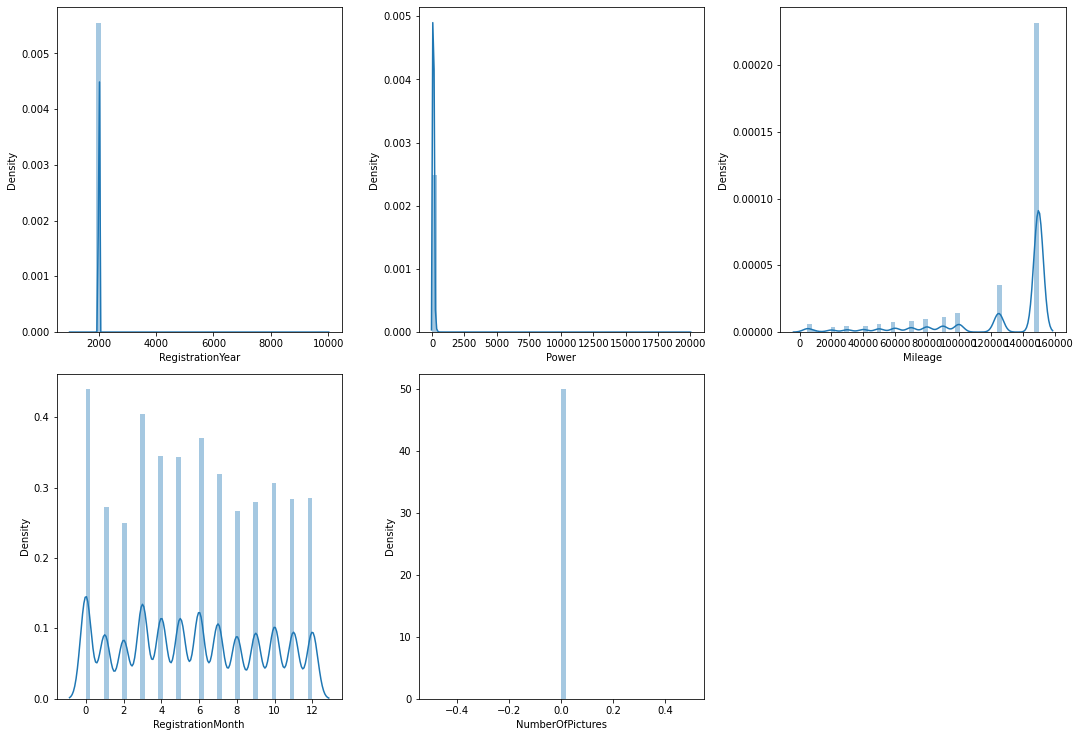

In [25]:
# Melihat persebaran data kategorikal
plt.subplots(figsize=(15, 15))
 
# melihat persebaran data categorikal
numerical = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth','NumberOfPictures']
 
for i, col in enumerate(numerical):
    plt.subplot(3, 3, i + 1)
    sns.distplot(df[col])
     
plt.tight_layout()
plt.show()

In [26]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354075.000000,354075.000000,354075.000000,354075.000000,354075.000000,354075.0,354075.000000
mean,4416.407818,2004.235693,110.088216,128211.282920,5.714086,0.0,50506.857875
std,4514.359273,90.265205,189.922740,37907.128915,3.726688,0.0,25784.403198
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [27]:
df['NumberOfPictures'].value_counts()

0    354075
Name: NumberOfPictures, dtype: int64

<div class="alert-info">
    

<b>Note</b>

- Seluruh datanya yaitu 0, sehingga nantinya tidak dapat digunakan dalam proses pelatihan model

In [28]:
# Memotong outlier pada kolom Registration Year

df.drop(df[(df['RegistrationYear']<1924) & (df['RegistrationYear']>2024)].index, inplace=True)
df.reset_index(drop=True, inplace=True)


In [29]:
df['age_of_vehicle'] = 2024 - df['RegistrationYear']

In [30]:
df['age_of_vehicle']

0         31
1         13
2         20
3         23
4         16
          ..
354070    19
354071    19
354072    24
354073    28
354074    22
Name: age_of_vehicle, Length: 354075, dtype: int64

In [31]:
# Melakukan mapping pada data kategorikal
 
# Mapping kolom "Gearbox" ('Manual' adalah 0, 'Auto' adalah 1)
df['Gearbox'] = df['Gearbox'].map({'manual': 0, 'auto': 1})
 
# Mapping kolom "NotRepaired" ('No' adalah 0, 'Yes' adalah 1)
df['NotRepaired'] = df['NotRepaired'].map({'no': 0, 'yes': 1})
 
# Display the DataFrame's first few rows to show the transformations
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,age_of_vehicle
0,24/03/2016 11:52,480,other,1993,0,0,golf,150000,0,petrol,volkswagen,0,24/03/2016 00:00,0,70435,07/04/2016 03:16,31
1,24/03/2016 10:58,18300,coupe,2011,0,190,other,125000,5,gasoline,audi,1,24/03/2016 00:00,0,66954,07/04/2016 01:46,13
2,14/03/2016 12:52,9800,suv,2004,1,163,grand,125000,8,gasoline,jeep,0,14/03/2016 00:00,0,90480,05/04/2016 12:47,20
3,17/03/2016 16:54,1500,small,2001,0,75,golf,150000,6,petrol,volkswagen,0,17/03/2016 00:00,0,91074,17/03/2016 17:40,23
4,31/03/2016 17:25,3600,small,2008,0,69,fabia,90000,7,gasoline,skoda,0,31/03/2016 00:00,0,60437,06/04/2016 10:17,16


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354075 entries, 0 to 354074
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354075 non-null  object
 1   Price              354075 non-null  int64 
 2   VehicleType        354075 non-null  object
 3   RegistrationYear   354075 non-null  int64 
 4   Gearbox            354075 non-null  int64 
 5   Power              354075 non-null  int64 
 6   Model              354075 non-null  object
 7   Mileage            354075 non-null  int64 
 8   RegistrationMonth  354075 non-null  int64 
 9   FuelType           354075 non-null  object
 10  Brand              354075 non-null  object
 11  NotRepaired        354075 non-null  int64 
 12  DateCreated        354075 non-null  object
 13  NumberOfPictures   354075 non-null  int64 
 14  PostalCode         354075 non-null  int64 
 15  LastSeen           354075 non-null  object
 16  age_of_vehicle     3

## Pelatihan Model

In [33]:
# Menghilangkan type data kategoric yang memiliki cukup banyak varian dan tidak dapat dijadikan feature.
df = df.drop(['DateCrawled' , 'RegistrationYear' , 'DateCreated', 'RegistrationMonth', 'Model', 'LastSeen','NumberOfPictures', 'PostalCode'], axis=1)

In [34]:
# One hot encoding ke data yang memiliki tipe data kategorikal nominal
data = pd.get_dummies(data=df, drop_first=True).astype('int')

In [35]:
# Membagi X train dan y train
X = data.drop('Price', axis=1)
y = data['Price']

In [36]:
X

,Gearbox,Power,Mileage,NotRepaired,age_of_vehicle,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,0,0,150000,0,31,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,190,125000,1,13,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,163,125000,0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,75,150000,0,23,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,69,90000,0,16,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354070,0,0,150000,1,19,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
354071,0,0,20000,0,19,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
354072,1,101,125000,0,24,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354073,0,102,150000,0,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354075 entries, 0 to 354074
Data columns (total 57 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Gearbox                  354075 non-null  int64
 1   Power                    354075 non-null  int64
 2   Mileage                  354075 non-null  int64
 3   NotRepaired              354075 non-null  int64
 4   age_of_vehicle           354075 non-null  int64
 5   VehicleType_convertible  354075 non-null  int64
 6   VehicleType_coupe        354075 non-null  int64
 7   VehicleType_other        354075 non-null  int64
 8   VehicleType_sedan        354075 non-null  int64
 9   VehicleType_small        354075 non-null  int64
 10  VehicleType_suv          354075 non-null  int64
 11  VehicleType_wagon        354075 non-null  int64
 12  FuelType_electric        354075 non-null  int64
 13  FuelType_gasoline        354075 non-null  int64
 14  FuelType_hybrid          354075 non-

In [38]:
# Train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=12)

In [39]:
X_train.shape, X_val.shape

((265556, 57), (88519, 57))

### Linear Regression

In [40]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [41]:
lr_pred = lr.predict(X_val)

In [42]:
# Calculate RMSE
rmse = np.sqrt(mse(y_val, lr_pred))

print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 3419.9005802904935


In [43]:
y_val.shape

(88519,)

### Random Forrest Regression

In [44]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=20, random_state=0)

In [45]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

In [46]:
# Make predictions on the test set
rf_pred = rf_model.predict(X_val)

In [47]:
# Calculate RMSE
rmse = np.sqrt(mse(y_val, rf_pred))

print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1825.118347557872


### Xgb Regression

In [48]:
xgb = XGBRegressor(n_estimators=20).fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)

In [49]:
# Calculate RMSE
rmse = np.sqrt(mse(y_val, xgb_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1960.59625879506


### Light GBM Regression

In [50]:
gbr = GradientBoostingRegressor(n_estimators=20).fit(X_train, y_train)
gbr_pred = gbr.predict(X_val)

In [51]:
# Calculate RMSE
rmse = np.sqrt(mse(y_val, gbr_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 2571.7029267247844


In [52]:
#Standarisasi Fitur
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [53]:
# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(X_train, label=y_train) 
  
# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [54]:
# Define a dictionary of parameters for configuring the LightGBM regression model. 
params = { 
    'objective': 'regression', 
    'metric': 'rmse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
} 

In [55]:
num_round = 10000
bst = lgb.train(params, train_data, num_round, valid_sets=[ 
                test_data], early_stopping_rounds=10) 

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 265556, number of used features: 57
[LightGBM] [Info] Start training from score 4411.099745
[1]	valid_0's rmse: 4372.97
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 4226.71
[3]	valid_0's rmse: 4102
[4]	valid_0's rmse: 3972.93
[5]	valid_0's rmse: 3852.38
[6]	valid_0's rmse: 3755.94
[7]	valid_0's rmse: 3648
[8]	valid_0's rmse: 3548.18
[9]	valid_0's rmse: 3453.82
[10]	valid_0's rmse: 3367.53
[11]	valid_0's rmse: 3297.05
[12]	valid_0's rmse: 3219.38
[13]	valid_0's rmse: 3147.36
[14]	valid_0's rmse: 3080.34
[15]	valid_0's rmse: 3017.23
[16]	valid_0's rmse: 2959.37
[17]	valid_0's rmse: 2904.5
[18]	valid_0's rmse: 2853.35
[19]	valid_0's rmse: 

[268]	valid_0's rmse: 1874.3
[269]	valid_0's rmse: 1874.17
[270]	valid_0's rmse: 1873.97
[271]	valid_0's rmse: 1873.76
[272]	valid_0's rmse: 1873.57
[273]	valid_0's rmse: 1873.04
[274]	valid_0's rmse: 1872.88
[275]	valid_0's rmse: 1872.52
[276]	valid_0's rmse: 1872.37
[277]	valid_0's rmse: 1872.17
[278]	valid_0's rmse: 1872.04
[279]	valid_0's rmse: 1871.85
[280]	valid_0's rmse: 1871.54
[281]	valid_0's rmse: 1871.47
[282]	valid_0's rmse: 1871.36
[283]	valid_0's rmse: 1871.12
[284]	valid_0's rmse: 1870.9
[285]	valid_0's rmse: 1870.77
[286]	valid_0's rmse: 1870.37
[287]	valid_0's rmse: 1870.29
[288]	valid_0's rmse: 1870.11
[289]	valid_0's rmse: 1869.94
[290]	valid_0's rmse: 1869.73
[291]	valid_0's rmse: 1869.62
[292]	valid_0's rmse: 1869.4
[293]	valid_0's rmse: 1869.29
[294]	valid_0's rmse: 1869.11
[295]	valid_0's rmse: 1868.88
[296]	valid_0's rmse: 1868.73
[297]	valid_0's rmse: 1868.56
[298]	valid_0's rmse: 1868.37
[299]	valid_0's rmse: 1868.21
[300]	valid_0's rmse: 1868.04
[301]	valid_0

[544]	valid_0's rmse: 1833.95
[545]	valid_0's rmse: 1833.86
[546]	valid_0's rmse: 1833.76
[547]	valid_0's rmse: 1833.68
[548]	valid_0's rmse: 1833.67
[549]	valid_0's rmse: 1833.63
[550]	valid_0's rmse: 1833.54
[551]	valid_0's rmse: 1833.43
[552]	valid_0's rmse: 1833.43
[553]	valid_0's rmse: 1833.22
[554]	valid_0's rmse: 1833.09
[555]	valid_0's rmse: 1832.98
[556]	valid_0's rmse: 1832.94
[557]	valid_0's rmse: 1832.88
[558]	valid_0's rmse: 1832.8
[559]	valid_0's rmse: 1832.67
[560]	valid_0's rmse: 1832.59
[561]	valid_0's rmse: 1832.46
[562]	valid_0's rmse: 1832.3
[563]	valid_0's rmse: 1832.26
[564]	valid_0's rmse: 1832.14
[565]	valid_0's rmse: 1831.97
[566]	valid_0's rmse: 1831.79
[567]	valid_0's rmse: 1831.75
[568]	valid_0's rmse: 1831.7
[569]	valid_0's rmse: 1831.71
[570]	valid_0's rmse: 1831.61
[571]	valid_0's rmse: 1831.46
[572]	valid_0's rmse: 1831.42
[573]	valid_0's rmse: 1831.41
[574]	valid_0's rmse: 1831.34
[575]	valid_0's rmse: 1831.26
[576]	valid_0's rmse: 1831.15
[577]	valid_0

[823]	valid_0's rmse: 1810.99
[824]	valid_0's rmse: 1810.86
[825]	valid_0's rmse: 1810.74
[826]	valid_0's rmse: 1810.58
[827]	valid_0's rmse: 1810.54
[828]	valid_0's rmse: 1810.45
[829]	valid_0's rmse: 1810.42
[830]	valid_0's rmse: 1810.36
[831]	valid_0's rmse: 1810.31
[832]	valid_0's rmse: 1810.27
[833]	valid_0's rmse: 1810.23
[834]	valid_0's rmse: 1810.19
[835]	valid_0's rmse: 1810.14
[836]	valid_0's rmse: 1810.12
[837]	valid_0's rmse: 1810.11
[838]	valid_0's rmse: 1810.1
[839]	valid_0's rmse: 1809.95
[840]	valid_0's rmse: 1809.94
[841]	valid_0's rmse: 1809.86
[842]	valid_0's rmse: 1809.79
[843]	valid_0's rmse: 1809.77
[844]	valid_0's rmse: 1809.78
[845]	valid_0's rmse: 1809.71
[846]	valid_0's rmse: 1809.76
[847]	valid_0's rmse: 1809.75
[848]	valid_0's rmse: 1809.75
[849]	valid_0's rmse: 1809.61
[850]	valid_0's rmse: 1809.36
[851]	valid_0's rmse: 1809.16
[852]	valid_0's rmse: 1809.07
[853]	valid_0's rmse: 1809.05
[854]	valid_0's rmse: 1808.96
[855]	valid_0's rmse: 1808.87
[856]	valid

[1100]	valid_0's rmse: 1797.35
[1101]	valid_0's rmse: 1797.32
[1102]	valid_0's rmse: 1797.31
[1103]	valid_0's rmse: 1797.28
[1104]	valid_0's rmse: 1797.22
[1105]	valid_0's rmse: 1797.16
[1106]	valid_0's rmse: 1797.11
[1107]	valid_0's rmse: 1797.1
[1108]	valid_0's rmse: 1797.09
[1109]	valid_0's rmse: 1797.01
[1110]	valid_0's rmse: 1797.04
[1111]	valid_0's rmse: 1797.06
[1112]	valid_0's rmse: 1797.05
[1113]	valid_0's rmse: 1797.06
[1114]	valid_0's rmse: 1796.97
[1115]	valid_0's rmse: 1796.96
[1116]	valid_0's rmse: 1796.95
[1117]	valid_0's rmse: 1796.89
[1118]	valid_0's rmse: 1796.77
[1119]	valid_0's rmse: 1796.75
[1120]	valid_0's rmse: 1796.71
[1121]	valid_0's rmse: 1796.64
[1122]	valid_0's rmse: 1796.66
[1123]	valid_0's rmse: 1796.64
[1124]	valid_0's rmse: 1796.62
[1125]	valid_0's rmse: 1796.58
[1126]	valid_0's rmse: 1796.47
[1127]	valid_0's rmse: 1796.44
[1128]	valid_0's rmse: 1796.41
[1129]	valid_0's rmse: 1796.38
[1130]	valid_0's rmse: 1796.32
[1131]	valid_0's rmse: 1796.29
[1132]	va

[1369]	valid_0's rmse: 1788.47
[1370]	valid_0's rmse: 1788.45
[1371]	valid_0's rmse: 1788.36
[1372]	valid_0's rmse: 1788.34
[1373]	valid_0's rmse: 1788.33
[1374]	valid_0's rmse: 1788.32
[1375]	valid_0's rmse: 1788.31
[1376]	valid_0's rmse: 1788.25
[1377]	valid_0's rmse: 1788.21
[1378]	valid_0's rmse: 1788.18
[1379]	valid_0's rmse: 1788.12
[1380]	valid_0's rmse: 1788.11
[1381]	valid_0's rmse: 1788.07
[1382]	valid_0's rmse: 1788.06
[1383]	valid_0's rmse: 1788.07
[1384]	valid_0's rmse: 1788.07
[1385]	valid_0's rmse: 1788.07
[1386]	valid_0's rmse: 1788.06
[1387]	valid_0's rmse: 1788.05
[1388]	valid_0's rmse: 1788.03
[1389]	valid_0's rmse: 1788.01
[1390]	valid_0's rmse: 1788.02
[1391]	valid_0's rmse: 1787.89
[1392]	valid_0's rmse: 1787.88
[1393]	valid_0's rmse: 1787.87
[1394]	valid_0's rmse: 1787.86
[1395]	valid_0's rmse: 1787.82
[1396]	valid_0's rmse: 1787.74
[1397]	valid_0's rmse: 1787.69
[1398]	valid_0's rmse: 1787.68
[1399]	valid_0's rmse: 1787.63
[1400]	valid_0's rmse: 1787.61
[1401]	v

In [56]:
# LightGBM Regression
lgbm_reg = LGBMRegressor(metric='rmse')
lgbm_reg.fit(X_train, y_train)

LGBMRegressor(metric='rmse')

In [57]:
Y_train = lgbm_reg.predict(X_train) 
Y_val = lgbm_reg.predict(X_val)

In [58]:
# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions. 
print("Training RMSE: ", np.sqrt(mse(Y_train, y_train))) 
print("Validation RMSE: ", np.sqrt(mse(Y_val, y_val))) 

Training RMSE:  1860.581890013172
Validation RMSE:  1896.2320020063732


## Analisis Model

### Kualitas Prediksi

In [64]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=20, random_state=42)),
    ('Xgb Regression', XGBRegressor(n_estimators=20)),
    ('Light GBM Regression', LGBMRegressor(metric='rmse'))
    
]

evaluation_metrics = {'Model': [], 'RMSE': []}

In [91]:
evaluation_metrics = {'Model': [], 'RMSE': [], 'train_time' : [], 'pred_time': []}

In [93]:
for name, model in models:
    start_train_time = time.time_ns()
    model.fit(X_train, y_train)
    end_train_time = time.time_ns()
    
    start_pred_time = time.time_ns()
    y_pred = model.predict(X_val)
    end_pred_time = time.time_ns()
    
    
    RMSE = np.sqrt(mse(y_val, y_pred))
    train_timer = start_train_time - end_train_time
    pred_timer = start_pred_time - end_pred_time
    
    
    
    evaluation_metrics['Model'].append(name)
    evaluation_metrics['RMSE'].append(RMSE)
    evaluation_metrics['train_time'].append(train_timer)
    evaluation_metrics['pred_time'].append(pred_timer)

In [94]:
evaluation_metrics_df = pd.DataFrame(evaluation_metrics)
evaluation_metrics_df

,Model,RMSE,train_time,pred_time
0,Linear Regression,3419.900580,-2186822053,-5063349
1,Random Forest,1825.632383,-39728244886,-895595271
2,Xgb Regression,1960.596259,-24304780514,-186805694
3,Light GBM Regression,1896.232002,-6078309476,-822331089


<div class="alert-info">
    

<b>Insight</b>

- RMSE Terkecil ditemukan pada model Random Forest, Namun memerlukan waktu lebih lama dalam proses pelatihan dan prediksi yang berbanding terbalik dengan Model Linear Regression. Linear Regression Memiliki waktu lebih cepat namun memiliki nilai RMSE yang paling banyak.
    
- Model Light GBM Regression memiliki value paling optimal, dimana nilai RMSE tidak jauh berbeda dengan Random Forest dan memiliki waktu proses pelatihan dan prediksi lebih cepat.